### Question 4 - Sensor coverage
Compute the set of (disjoint) connected components (areas) defined over a grid of 2 Km x 2  Km cells. 

A grid cell is occupied, if there is at least one sensor whose coordinates fall in the given grid. Two grid cells belong to the same component (area), if the they are neighbours (horizontally or vertically). 

For simplicity, assume that .008983112 latitude degrees correspond to 1Km (North/South), and .011972 longitude degrees to 1KM(East/West).

The result should be computed for a period spanning the last 3 days of the provided dataset. To name the computed areas use the pair (sensor_id, city) closest to area "centroid" cell.

**Requeriment**: For this question, use a single framework of your choice, of those studied.

In [1]:
#@title Mount Google Drive
from google.colab import drive
drive.mount('/content/drive') # Faz o mount da drive

Mounted at /content/drive


In [2]:
#@title Install Pyspark
!pip install --quiet pyspark # Faz a instalação do Pyspark

     |████████████████████████████████| 281.4 MB 43 kB/s 
     |████████████████████████████████| 199 kB 66.4 MB/s 


In [3]:
#@title Install Spark GraphFrames
!pip install --quiet graphframes # Faz a instalação do GraphFrames

     |████████████████████████████████| 154 kB 6.6 MB/s 


In [39]:
#@title Install GeoPandas
!pip install --quiet geopandas

     |████████████████████████████████| 1.1 MB 4.7 MB/s 
     |████████████████████████████████| 16.6 MB 92 kB/s 
     |████████████████████████████████| 7.8 MB 50.6 MB/s 


In [42]:
#@title Install Shapely
!pip install --quiet shapely

In [4]:
#@title Dataset
!head -10000 /content/drive/MyDrive/projeto_spbd/sds011-2020-06-30.csv > files 
# Dataset utilizado. Este dataset foi apenas utilizado para parte de um dia para facilitar o tempo de computação.

In [32]:
#@title Resolution using Spark SQL
import pandas as pd
import numpy as np
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from graphframes import *
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from google.colab import files

main_data = "/content/files" # Dataset principal
aux_data = "/content/drive/MyDrive/projeto_spbd/sensors_all.json" # Dataset secundário

spark = SparkSession.builder.master('local[*]').appName('/content/files').config('spark.jars.packages', 'graphframes:graphframes:0.8.2-spark3.1-s_2.12').getOrCreate() # É iniciada a SparkSession, em local mode
sc = spark.sparkContext # Cria o SparkContext

custom_schema = StructType([StructField("sen_id", StringType(), True),StructField("file_id", StringType(), True),StructField("lat", FloatType(), True),StructField("lon", FloatType(), True),StructField("timestamp", TimestampType(), True),StructField("p1", FloatType(), True),StructField("p2", FloatType(), True),])
# É criado um schema para o DataFrame
df1 = spark.read.csv(main_data, header=False, sep=';', schema=custom_schema) # Lê o ficheiro csv
df2 = spark.read.json(aux_data) # Lê o ficheiro JSON
df1.createOrReplaceTempView('df1_tv') # Cria uma Temporary View do ficheiro csv
df2.createOrReplaceTempView('df2_tv') # Cria uma Temporary View do ficheiro JSON

df_joint = spark.sql('SELECT DISTINCT country, city, ROUND(lat, 4) AS latitude, ROUND(lon, 4) AS longitude, df2_tv.sensor_id FROM df2_tv \
JOIN df1_tv ON df1_tv.sen_id = df2_tv.sensor_id ORDER BY latitude, longitude') # Faz o JOIN dos dois datasets e apresenta os dados das colunas country, city, latitude, longitude, sensor_id
df_joint.createOrReplaceTempView('df_joint_tv') # Cria uma Temporary View do df_joint
df_joint.show()

df_edges = spark.sql('SELECT min(latitude) AS lat_min, max(latitude) \
AS lat_max, min(longitude) AS lon_min, max(longitude) AS lon_max FROM df_joint_tv') # Apresenta a latitudes máxima e mínima, e longitude máxima e mínima.
df_edges.show()

+--------+--------------------+--------+---------+---------+
| country|                city|latitude|longitude|sensor_id|
+--------+--------------------+--------+---------+---------+
|   Spain|Santa Cruz de Ten...|  28.466|  -16.274|    34030|
|   Spain|             Melilla|  35.296|   -2.944|    18241|
|   Spain|              Málaga|  36.691|  -4.4488|    42826|
|   Spain|              Málaga|  36.691|  -4.4487|    46671|
|   Spain|              Málaga| 36.6912|  -4.4531|    39596|
|   Spain|              Málaga| 36.6912|  -4.4486|    36109|
|   Spain|              Málaga| 36.7102|  -4.4454|    37985|
|   Spain|              Málaga|  36.728|   -4.414|    47617|
|Portugal|               Lagos| 37.0919|  -8.6831|    25874|
|   Spain|San Silvestre de ...|  37.354|   -7.442|    17016|
|   Spain|               Altea|  38.578|   -0.066|    43182|
|Portugal|            Corroios|  38.646|   -9.154|     4638|
|   Spain|             Moraira|  38.704|    0.152|    10174|
|Portugal|              

In [33]:
#@title Setting the Grid
lat_min = df_edges.collect()[0][0]; lat_max = df_edges.collect()[0][1]; lon_min = df_edges.collect()[0][2]; lon_max = df_edges.collect()[0][3] 
# Vai buscar os valores das latitudes máxima e mínima e longitudes máxima e mínima.
longitude_dimension = 1.0; latitude_dimension = 1.0 # Estabelece as dimensões da grelha

# Cria e alimenta uma lista com os valores de longitude
lon_values = []
lon_atual = lon_min
while lon_atual < lon_max:
    lon_values.append(lon_atual)
    lon_atual = lon_atual + longitude_dimension

# Cria e alimenta uma lista com os valores de latitude
lat_values = []
lat_atual = lat_min
while lat_atual < lat_max:
    lat_values.append(lat_atual)
    lat_atual = lat_atual + latitude_dimension

grelha = [(lon, lat, i, j) for i, lon in enumerate(lon_values) for j, lat in enumerate(lat_values)] # Cria uma lista de tuples (longitude, latitude)

df_grelha = spark.createDataFrame(grelha, ["lon", "lat", "i", "j"]) # Transforma a lista de tuples criada anteriormente para um Spark DataFrame

df_grelha.createOrReplaceTempView("matrix") # Cria uma Temporary View da df_grelha

presence_grid = spark.sql(f"SELECT DISTINCT 'unit('||i||','||j||')' AS id, i, j, lat, lon FROM (SELECT CASE WHEN (longitude between lon and lon+{longitude_dimension}) and (latitude between lat and lat+{latitude_dimension}) \
THEN 1 ELSE 0 END Gk, i, j, ROUND(n.lat, 4) AS lat, ROUND(n.lon, 4) AS lon, m.* \
FROM matrix AS n CROSS JOIN (SELECT DISTINCT ROUND(lat, 4) AS latitude, ROUND(lon, 4) AS longitude FROM df2_tv \
JOIN df1_tv ON df2_tv.sensor_id = df1_tv.sen_id ORDER BY latitude, longitude) as m) WHERE Gk=1 ORDER BY i, j")
# Esta query verifica quais as units da grelha que têm sensores

grelha_input = presence_grid # Guarda os resultados num DataFrame novo, por forma a poder ser utilizado mais tarde
grelha_input_final = grelha_input.drop("lat","lon") # Faz o Drop das colunas "lat" e "lon"

grelha_input_final.show() # Apresenta os resultados da grelha_input_final

+-----------+---+---+
|         id|  i|  j|
+-----------+---+---+
|  unit(0,0)|  0|  0|
|  unit(7,8)|  7|  8|
| unit(7,10)|  7| 10|
| unit(7,11)|  7| 11|
| unit(7,12)|  7| 12|
|  unit(8,8)|  8|  8|
|unit(10,15)| 10| 15|
| unit(11,8)| 11|  8|
|unit(11,19)| 11| 19|
|unit(12,11)| 12| 11|
|unit(12,12)| 12| 12|
|unit(12,19)| 12| 19|
|unit(12,20)| 12| 20|
| unit(13,6)| 13|  6|
|unit(13,14)| 13| 14|
|unit(13,20)| 13| 20|
|unit(14,10)| 14| 10|
|unit(14,15)| 14| 15|
|unit(14,18)| 14| 18|
|unit(14,19)| 14| 19|
+-----------+---+---+
only showing top 20 rows



In [7]:
#@title Verifying the Neighbourhood
grelha_input_final = grelha_input_final.crossJoin(grelha_input_final.withColumnRenamed("i","i2").withColumnRenamed("j", "j2").withColumnRenamed("id", "id2"))
grelha_input_final.show(truncate=False)

def _areNeighbours(li, lj, ri, rj):
    dx = li - ri
    dy = lj - rj
    return (dx >= 0 and dx <= 1 and dy == 0) or (dx == 0 and dy >= 0 and dy <= 1)

areNeighbours = udf(_areNeighbours)
grelha_input_final = grelha_input_final.select('*', areNeighbours(grelha_input_final.i, grelha_input_final.j, grelha_input_final.i2, grelha_input_final.j2).alias("adjacent")) \

grelha_input_final = grelha_input_final.filter(grelha_input_final.adjacent == True).drop('adjacent')
grelha_input_final.printSchema()

grelha_input_final.show(truncate=False)

+---------+---+---+-----------+---+---+
|id       |i  |j  |id2        |i2 |j2 |
+---------+---+---+-----------+---+---+
|unit(0,0)|0  |0  |unit(0,0)  |0  |0  |
|unit(0,0)|0  |0  |unit(7,8)  |7  |8  |
|unit(0,0)|0  |0  |unit(7,10) |7  |10 |
|unit(0,0)|0  |0  |unit(7,11) |7  |11 |
|unit(0,0)|0  |0  |unit(7,12) |7  |12 |
|unit(0,0)|0  |0  |unit(8,8)  |8  |8  |
|unit(0,0)|0  |0  |unit(10,15)|10 |15 |
|unit(0,0)|0  |0  |unit(11,8) |11 |8  |
|unit(0,0)|0  |0  |unit(11,19)|11 |19 |
|unit(0,0)|0  |0  |unit(12,11)|12 |11 |
|unit(0,0)|0  |0  |unit(12,12)|12 |12 |
|unit(0,0)|0  |0  |unit(12,19)|12 |19 |
|unit(0,0)|0  |0  |unit(12,20)|12 |20 |
|unit(0,0)|0  |0  |unit(13,6) |13 |6  |
|unit(0,0)|0  |0  |unit(13,14)|13 |14 |
|unit(0,0)|0  |0  |unit(13,20)|13 |20 |
|unit(0,0)|0  |0  |unit(14,10)|14 |10 |
|unit(0,0)|0  |0  |unit(14,15)|14 |15 |
|unit(0,0)|0  |0  |unit(14,18)|14 |18 |
|unit(0,0)|0  |0  |unit(14,19)|14 |19 |
+---------+---+---+-----------+---+---+
only showing top 20 rows

root
 |-- id: 

In [8]:
#@title Connections Components
vertices = grelha_input_final.select(grelha_input_final.id).distinct()
edges = grelha_input_final.select(grelha_input_final.id.alias("src"), grelha_input_final.id2.alias("dst"))

spark.sparkContext.setCheckpointDir(".")
g = GraphFrame(vertices, edges)

result = g.connectedComponents()
result.select("id", "component").orderBy("component").show()

+-----------+
|         id|
+-----------+
|unit(18,11)|
|unit(33,23)|
|unit(24,18)|
|unit(24,24)|
|unit(39,22)|
|unit(38,23)|
|unit(28,21)|
|unit(29,23)|
|unit(15,20)|
|unit(25,19)|
|unit(25,23)|
|unit(26,19)|
|unit(35,25)|
|unit(23,23)|
|unit(23,20)|
|unit(30,23)|
|unit(19,21)|
|unit(16,14)|
|  unit(8,8)|
|unit(26,26)|
+-----------+
only showing top 20 rows

+-----------+-----------+
|        src|        dst|
+-----------+-----------+
|unit(18,20)|unit(18,20)|
|unit(18,20)|unit(17,20)|
|unit(18,20)|unit(18,19)|
|unit(18,16)|unit(18,16)|
|  unit(8,8)|  unit(8,8)|
|  unit(8,8)|  unit(7,8)|
|unit(17,20)|unit(17,20)|
|unit(17,20)|unit(16,20)|
|unit(17,20)|unit(17,19)|
|unit(13,20)|unit(13,20)|
|unit(13,20)|unit(12,20)|
|unit(14,20)|unit(13,20)|
|unit(14,20)|unit(14,20)|
|unit(14,20)|unit(14,19)|
|unit(12,19)|unit(12,19)|
|unit(12,19)|unit(11,19)|
|unit(13,14)|unit(13,14)|
|unit(16,17)|unit(16,17)|
|unit(16,17)|unit(16,16)|
|unit(15,19)|unit(15,19)|
+-----------+-----------+
only showing t

/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+-----------+-----------+
|         id|  component|
+-----------+-----------+
|unit(18,13)|25769803776|
|unit(18,14)|25769803776|
|unit(18,11)|25769803776|
|unit(18,12)|25769803776|
|unit(26,21)|25769803777|
|unit(24,18)|25769803777|
|unit(33,23)|25769803777|
|unit(36,21)|25769803777|
|unit(39,22)|25769803777|
|unit(28,21)|25769803777|
|unit(23,22)|25769803777|
|unit(26,19)|25769803777|
|unit(23,23)|25769803777|
|unit(30,23)|25769803777|
|unit(31,23)|25769803777|
|unit(38,21)|25769803777|
|unit(25,19)|25769803777|
|unit(22,21)|25769803777|
|unit(37,21)|25769803777|
|unit(28,25)|25769803777|
+-----------+-----------+
only showing top 20 rows



In [37]:
#@title Cities closest to the components centroids
result.createOrReplaceTempView("df_comp")
grelha_input.createOrReplaceTempView("df_loc")

query_final = spark.sql('SELECT sensor_id, city, ROUND(centroid_lat, 4) AS Latitude, ROUND(centroid_long, 4) \
AS Longitude FROM (SELECT *, RANK() OVER (PARTITION BY component ORDER BY component, distance ASC) \
AS rank FROM (SELECT component, city, sensor_id, centroid_lat, centroid_long, ROUND(sqrt(pow(centroid_lat-i.latitude, 2) + pow(centroid_long-i.longitude, 2)), 4) \
AS distance FROM (SELECT m.component, (min(n.lat) + max(n.lat)) / 2 AS centroid_lat, (min(n.lon) + max(n.lon)) / 2 \
AS centroid_long FROM df_comp AS m CROSS JOIN df_loc AS n on m.id=n.id GROUP BY component) CROSS JOIN df_joint_tv AS i)) WHERE rank=1')
# Esta query apresenta quais são as cidades mais próximas dos centroides de cada componente

query_final.show(50) # Apresenta os resultados

+---------+--------------------+--------+---------+
|sensor_id|                city|Latitude|Longitude|
+---------+--------------------+--------+---------+
|     6471|       Castelldefels|  40.966|    1.726|
|    36189|               Dohna|  50.466|   14.226|
|    46210|           Écouflant|  47.466|   -0.774|
|    46727| Bagnères-de-Bigorre|  42.466|   -0.274|
|    25874|               Lagos|  36.466|   -8.774|
|    25968|   Rochefort-du-Gard|  44.466|    4.726|
|    19782|              Getafe|  39.966|   -4.274|
|    28848|               Derio|  42.466|   -3.274|
|    40423|               Gijón|  43.466|   -6.274|
|    37175|            Albacete|  38.466|   -2.274|
|    34030|Santa Cruz de Ten...|  28.466|  -16.274|
|    38531|            Zaragoza|  41.466|   -1.274|
|    27941|             Antibes|  43.466|    6.726|
|    39596|              Málaga|  36.466|   -5.274|
|    28176|       Porto-Vecchio|  41.466|    8.726|
|    12751|              Figeac|  44.466|    1.726|
|    45940| 

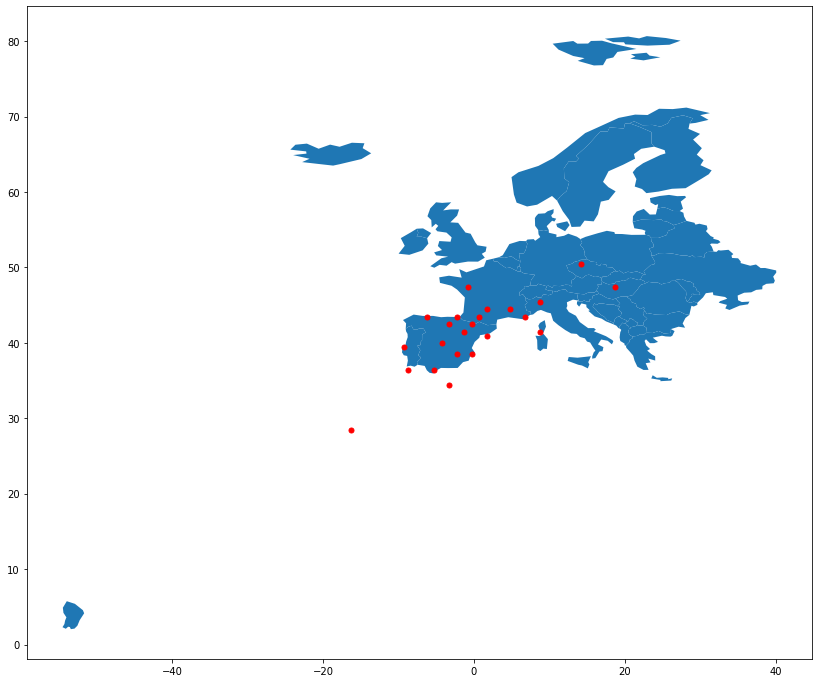

In [74]:
#@title Plotting the cities
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt

df = query_final.toPandas() # Tranforma para Pandas

geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])] # Descreve a latitude e longitude através da criação de Points
gdf = GeoDataFrame(df, geometry=geometry) # Cria a GeoDataFrame

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) # Carrega o mapa mundo
europe = world.loc[world['continent'] == 'Europe'] # Filtra os países apenas da Europa
europe_wr = europe.loc[europe['name'] != 'Russia'] # Retira a Rússia, por questão de dimensão
boundaries = europe_wr['geometry'] # Estabelece as boundaries
gdf.plot(ax=boundaries.plot(figsize=(20, 12)), marker='o', color='red', markersize=25) # Características do plot
plt.show() # Apresenta o mapa